# LIBRARIES

In [40]:
import numpy as np
import pickle
import tensorflow as tf
import os
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sklearn


# LOAD DATASET

In [41]:

path ='cifar-10-batches-py'


In [42]:

def load_cfar10_batch(path):
    with open(path + '/data_batch_1', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')   
    
    features = batch['data']
    labels = batch['labels']
    
    return features, labels


In [43]:
features,labels = load_cfar10_batch(path)

In [44]:
features.shape

(10000, 3072)

In [45]:
len(labels)

10000

# RESHAPE

In [46]:

x = features.reshape((len(features), 3, 32, 32)).transpose(0, 2, 3, 1) 
x.shape


(10000, 32, 32, 3)

# ONE HOT ENCODE

In [47]:
y = labels
def one_hot_encode(y):
    encoded = np.zeros((len(y), 10))
    
    for index, val in enumerate(y):
        encoded[index][val] = 1
    
    return encoded

encoded = one_hot_encode(y)

In [48]:
len(y)

10000

# NORMALIZE

In [49]:
def normalize(x):
    x_norm = x/255
    print (x_norm.min())
    print (x_norm.max())
    return x_norm
x_norm = normalize(x)

0.0
1.0


In [50]:
x_norm

array([[[[0.23137255, 0.24313725, 0.24705882],
         [0.16862745, 0.18039216, 0.17647059],
         [0.19607843, 0.18823529, 0.16862745],
         ...,
         [0.61960784, 0.51764706, 0.42352941],
         [0.59607843, 0.49019608, 0.4       ],
         [0.58039216, 0.48627451, 0.40392157]],

        [[0.0627451 , 0.07843137, 0.07843137],
         [0.        , 0.        , 0.        ],
         [0.07058824, 0.03137255, 0.        ],
         ...,
         [0.48235294, 0.34509804, 0.21568627],
         [0.46666667, 0.3254902 , 0.19607843],
         [0.47843137, 0.34117647, 0.22352941]],

        [[0.09803922, 0.09411765, 0.08235294],
         [0.0627451 , 0.02745098, 0.        ],
         [0.19215686, 0.10588235, 0.03137255],
         ...,
         [0.4627451 , 0.32941176, 0.19607843],
         [0.47058824, 0.32941176, 0.19607843],
         [0.42745098, 0.28627451, 0.16470588]],

        ...,

        [[0.81568627, 0.66666667, 0.37647059],
         [0.78823529, 0.6       , 0.13333333]

In [51]:
x_norm.shape

(10000, 32, 32, 3)

# WHITENING 

In [52]:
x[9999].shape

(32, 32, 3)

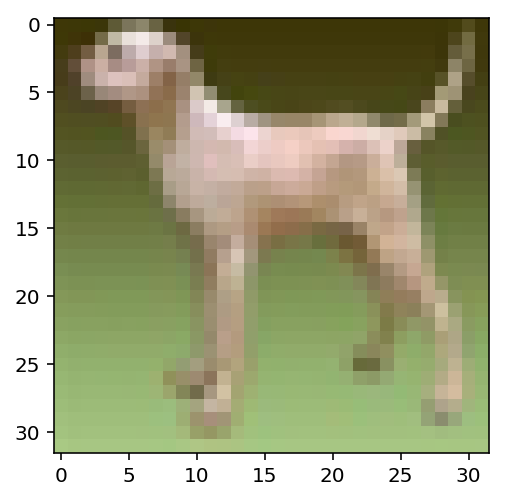

In [53]:
plt.imshow(x[9999])   #Original Image

c:\users\i_m_n\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
c:\users\i_m_n\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


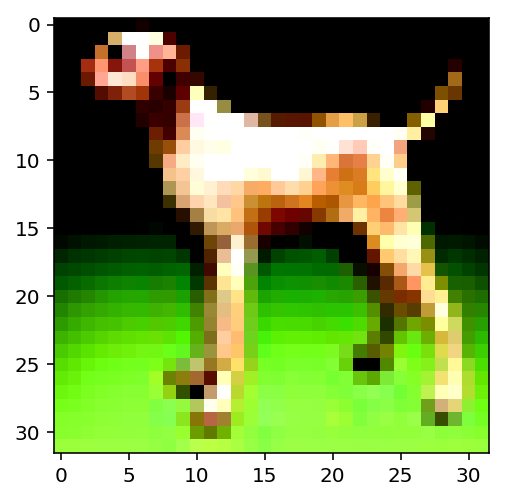

In [54]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(features)
scaled_df = scaled_df.reshape(10000,3,32,32).transpose(0,2,3,1)

plt.imshow(scaled_df[9999])  #Whitened Image

# SPLIT THE DATASET 80% 20%

In [55]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)
    

In [56]:
x_train.shape

(8000, 3072)

In [57]:
x_test.shape

(2000, 3072)

# SAVE THE RESULTS

In [58]:
def preprocess(normalize, one_hot_encode, features, labels, filename):
    features = normalize(x)    
    labels = one_hot_encode(y) 

    pickle.dump((features, labels), open(filename, 'wb')) 

In [59]:
   
def save_data(path, normalize, one_hot_encode):
    features, labels = load_cfar10_batch(path)
    
    preprocess(normalize, one_hot_encode, np.array(x_test), np.array(y_test), 'Preprocess_testing.p')
    preprocess(normalize, one_hot_encode, np.array(x_train), np.array(y_train), 'Preprocess_training.p') 

save_data(path, normalize, one_hot_encode)

0.0
1.0
0.0
1.0


In [60]:
x_test, y_test = pickle.load(open('Preprocess_testing.p', mode='rb'))
x_train, y_train = pickle.load(open('Preprocess_training.p', mode='rb'))

# PREPARE THE MODEL

In [61]:
def tf_reset():
    try:
        sess.close()
    except:
        pass
    tf.reset_default_graph()
    return tf.Session()

In [62]:
sess = tf_reset()

In [63]:
"""Inputs"""

x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='input_x') #image data to learn and predict
y =  tf.placeholder(tf.float32, shape=(None, 10), name='output_y')      #label data to compare with predicted output
keep_prob = tf.placeholder(tf.float32, name='keep_prob')                #probablity of units of each layer

In [85]:
"""Creating the model"""

def conv_net(x, keep_prob):
    
    conv1_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 3, 64]))    #64 filters in size 3x3
    conv2_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 128]))  #128 filters
    conv3_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 128, 256])) #256 filters
    conv4_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 256, 512])) #512 filters


 #Layer1
    conv1 = tf.nn.conv2d(x, conv1_filter, strides=[1,1,1,1], padding='SAME') #Computes 2D convolution given 4D i/p & filter tensors
    conv1 = tf.nn.relu(conv1)   #max(0, x)
    conv1_pool = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME') #move filter & chose max. value
    conv1_bn = tf.layers.batch_normalization(conv1_pool) #Calculate mean & variance, normalize, scale & shift

 #Layer2
    conv2 = tf.nn.conv2d(conv1_bn, conv2_filter, strides=[1,1,1,1], padding='SAME')
    conv2 = tf.nn.relu(conv2)
    conv2_pool = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')  #shrinks the same to half size
    conv2_bn = tf.layers.batch_normalization(conv2_pool)
  
 #Layer 3
    conv3 = tf.nn.conv2d(conv2_bn, conv3_filter, strides=[1,1,1,1], padding='SAME')
    conv3 = tf.nn.relu(conv3)
    conv3_pool = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')  
    conv3_bn = tf.layers.batch_normalization(conv3_pool)
    
 #Layer 4
    conv4 = tf.nn.conv2d(conv3_bn, conv4_filter, strides=[1,1,1,1], padding='SAME')
    conv4 = tf.nn.relu(conv4)
    conv4_pool = tf.nn.max_pool(conv4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv4_bn = tf.layers.batch_normalization(conv4_pool)
    
 
    flat = tf.contrib.layers.flatten(conv4_bn)   #flattening the output of the last convolving operations


    full1 = tf.contrib.layers.fully_connected(inputs=flat, num_outputs=128, activation_fn=tf.nn.relu) #fC Layer with 128 units
    full1 = tf.nn.dropout(full1, keep_prob) #ignores previous units/weights
    full1 = tf.layers.batch_normalization(full1)
    

    full2 = tf.contrib.layers.fully_connected(inputs=full1, num_outputs=256, activation_fn=tf.nn.relu)
    full2 = tf.nn.dropout(full2, keep_prob)
    full2 = tf.layers.batch_normalization(full2)
    

    full3 = tf.contrib.layers.fully_connected(inputs=full2, num_outputs=512, activation_fn=tf.nn.relu)
    full3 = tf.nn.dropout(full3, keep_prob)
    full3 = tf.layers.batch_normalization(full3)    
    

    full4 = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=1024, activation_fn=tf.nn.relu)
    full4 = tf.nn.dropout(full4, keep_prob)
    full4 = tf.layers.batch_normalization(full4)        

    
    out = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=10, activation_fn=None)
    
    return out    #Fully Connected Layer with 10 units (number of image classes)

# HYPERPARAMETERS

In [86]:
iterations = 101
batch_size = 128
keep_probability = 0.7
learning_rate = 0.001

# LOSS FUNCTION & OPTIMIZER

In [87]:
logits = conv_net(x, keep_prob)


cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))   #loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)     #optimizer


correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')  #accuracy

# TRAIN THE NETWORK

In [88]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    session.run(optimizer, 
                feed_dict={
                    x: feature_batch,
                    y: label_batch,
                    keep_prob: keep_probability
                })

In [89]:
def print_stats(sess, feature_batch, label_batch, cost, accuracy):
    loss = sess.run(cost, 
                    feed_dict={
                        x: feature_batch,
                        y: label_batch,
                        keep_prob: 1.
                    })
    valid_acc = sess.run(accuracy, 
                         feed_dict={
                             x: x_train,
                             y: y_train,
                             keep_prob: 1.
                         })
    
    print('Loss: {:>10.4f}, Accuracy: {:.6f}'.format(loss, valid_acc))

In [90]:
def batch_features_labels(features, labels, batch_size):   #split features and labels for the batch size
    
    features = features.reshape((len(features), 3, 32, 32)).transpose(0, 2, 3, 1)
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

def load_training(batch_size):   #load the Preprocessed Training data
    
    filename = 'Preprocess_training.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    return batch_features_labels(features, labels, batch_size)

# STATS

In [91]:


print('Training...')
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())  #initializing the variables
    
    
    for i in range(iterations):     #training cycle
        if i % 10 == 0:
            for feature_batch, label_batch in load_training(batch_size):
                train_neural_network(sess, optimizer, keep_probability, feature_batch, label_batch)
                
            print('Iterations {}, CIFAR-10 Batch 1:  '.format(i), end='')
            print_stats(sess, feature_batch, label_batch, cost, accuracy)
            


Training...
Iterations 0, CIFAR-10 Batch 1:  Loss:     2.3021, Accuracy: 0.099000
Iterations 10, CIFAR-10 Batch 1:  Loss:     2.3045, Accuracy: 0.100100
Iterations 20, CIFAR-10 Batch 1:  Loss:     2.3040, Accuracy: 0.100100
Iterations 30, CIFAR-10 Batch 1:  Loss:     2.3043, Accuracy: 0.100100
Iterations 40, CIFAR-10 Batch 1:  Loss:     2.3037, Accuracy: 0.100000
Iterations 50, CIFAR-10 Batch 1:  Loss:     2.3047, Accuracy: 0.100000
Iterations 60, CIFAR-10 Batch 1:  Loss:     2.3032, Accuracy: 0.100000
Iterations 70, CIFAR-10 Batch 1:  Loss:     2.3040, Accuracy: 0.100000
Iterations 80, CIFAR-10 Batch 1:  Loss:     2.3049, Accuracy: 0.100000
Iterations 90, CIFAR-10 Batch 1:  Loss:     2.3035, Accuracy: 0.100000
Iterations 100, CIFAR-10 Batch 1:  Loss:     2.3040, Accuracy: 0.100000


# TEST THE MODEL

In [92]:
def batch_features_labels(features, labels, batch_size):  #split features and labels 
    
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]
        
def load_testing(batch_size):   #load the Preprocessed Testing data
  
    filename = 'Preprocess.testing.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)






In [93]:

def print_stats(sess, accuracy):
    accuracy = sess.run(accuracy,
                  feed_dict={
                      x : x_test,
                      y : y_test,
                      keep_prob:1.0
                          
                  })
    print(accuracy)


In [94]:
print('Testing...')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())  #initializing the variables
    print(accuracy , end='')
    print()
    print_stats(sess, accuracy)


Testing...
Tensor("accuracy_1:0", shape=(), dtype=float32)
0.0917
